In [1]:
import matplotlib.pyplot as plt, PIL.Image as pil, mahotas as mh, skimage.segmentation as skseg, numpy as np, cv2

In [2]:
from scipy import ndimage as ndi

from skimage import data
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(data.camera()); print(image.shape, image.max(), image.min())  # Exmaple image

(512, 512) 255 0


In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Method 1: Gradient

In [20]:
img_path = 'Mouse_CV-CellSeg/BA85_DAPI/image/BA85_DAPI.png'

In [10]:
img = plt.imread(img_path);

In [12]:
@interact(stringency=(0,100,1), blur_factor = (1,50,1), blur_factor_2 = (1,10,1), blur_factor_3 = (1,10,1))
def Watershed(blur_factor = 16, blur_factor_2=5,stringency=10):
    # denoise image
    denoised = rank.mean(mh.stretch(img), disk(blur_factor)); print(denoised.shape)
    # find continuous region (low gradient - where less than 10 for this image) --> markers
    # disk(5) is used here to get a more smooth image  
    markers = rank.gradient(denoised, disk(blur_factor_2)) > stringency ;markers = ndi.label(markers)[0]
    # local gradient (disk(2) is used to keep edges thin)
    gradient = rank.gradient(denoised, disk(2)); print('Gradient matrix:', gradient.max(), gradient.min())
    # process the watershed
    labels = watershed(gradient, markers)
    # display results
    fig, axes = plt.subplots(2,2, figsize=(8, 8)); ax = axes.ravel(); fig.tight_layout()
    ax[0].imshow(denoised, cmap=plt.cm.gray); ax[0].set_title("denoised")
    ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral); ax[1].set_title("Local Gradient")
    ax[2].imshow(markers, cmap=plt.cm.nipy_spectral); ax[2].set_title("Markers")
    ax[3].imshow(img, cmap=plt.cm.gray); ax[3].set_title("Segmented");
    ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7); 
    print('Number of objects', len(np.unique(labels)))
    return labels

interactive(children=(IntSlider(value=16, description='blur_factor', max=50, min=1), IntSlider(value=5, descri…

### Method 2: Local Maxima Watershed

In [18]:
import numpy as np, scipy.ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank
from skimage.morphology import extrema
import mahotas as mh

In [20]:
img_path = 'Mouse_CV-CellSeg/BA85_DAPI/image/BA85_DAPI.png'

In [21]:
img = plt.imread(img_path); img_array = mh.stretch(np.array(img));

<b> Image Filtering

In [23]:
@interact(sigma=(0.1,3,0.1), blur_factor=(1,50,1))
def CompareBlur_noBlur(blur_factor=15, sigma=0.5):
    fig = plt.figure(figsize=(9,3)); fig.tight_layout(); 
    gaussian_f = mh.gaussian_filter(img, sigma = sigma); g_filter = gaussian_f>gaussian_f.mean()
    ax1 = fig.add_subplot(131); ax1.imshow(img*g_filter); ax1.set_title('gaussian')
    
    img_blurred= rank.mean(img, disk(blur_factor)); 
    plt.subplot(132); plt.imshow(img_blurred); plt.title('Blurred')
    gaussian_f = mh.gaussian_filter(img_blurred, sigma = sigma); 
    blurg_filter = gaussian_f>gaussian_f.mean(); filtered_img = img_blurred*blurg_filter;
    ax2 = fig.add_subplot(133); ax2.imshow(filtered_img); ax2.set_title('Blur then Gaussian (filtered_img)')
    return g_filter, img_blurred, blurg_filter, filtered_img

interactive(children=(IntSlider(value=15, description='blur_factor', max=50, min=1), FloatSlider(value=0.5, de…

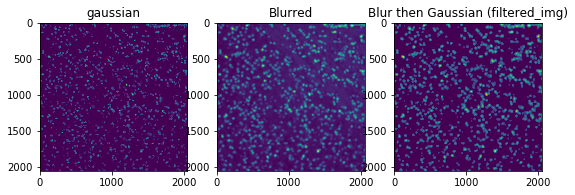

In [25]:
g_filter, img_blurred, blurg_filter, filtered_img = CompareBlur_noBlur(15, 0.5)

[  0.    26.75  53.5   80.25 107.  ]


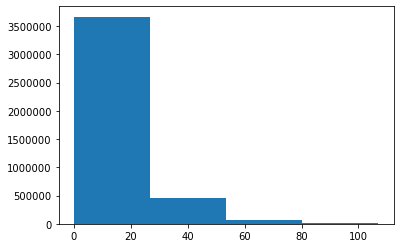

In [27]:
data = np.hstack(filtered_img); h = plt.hist(data, bins=4); print(h[1])

### Edge Detector

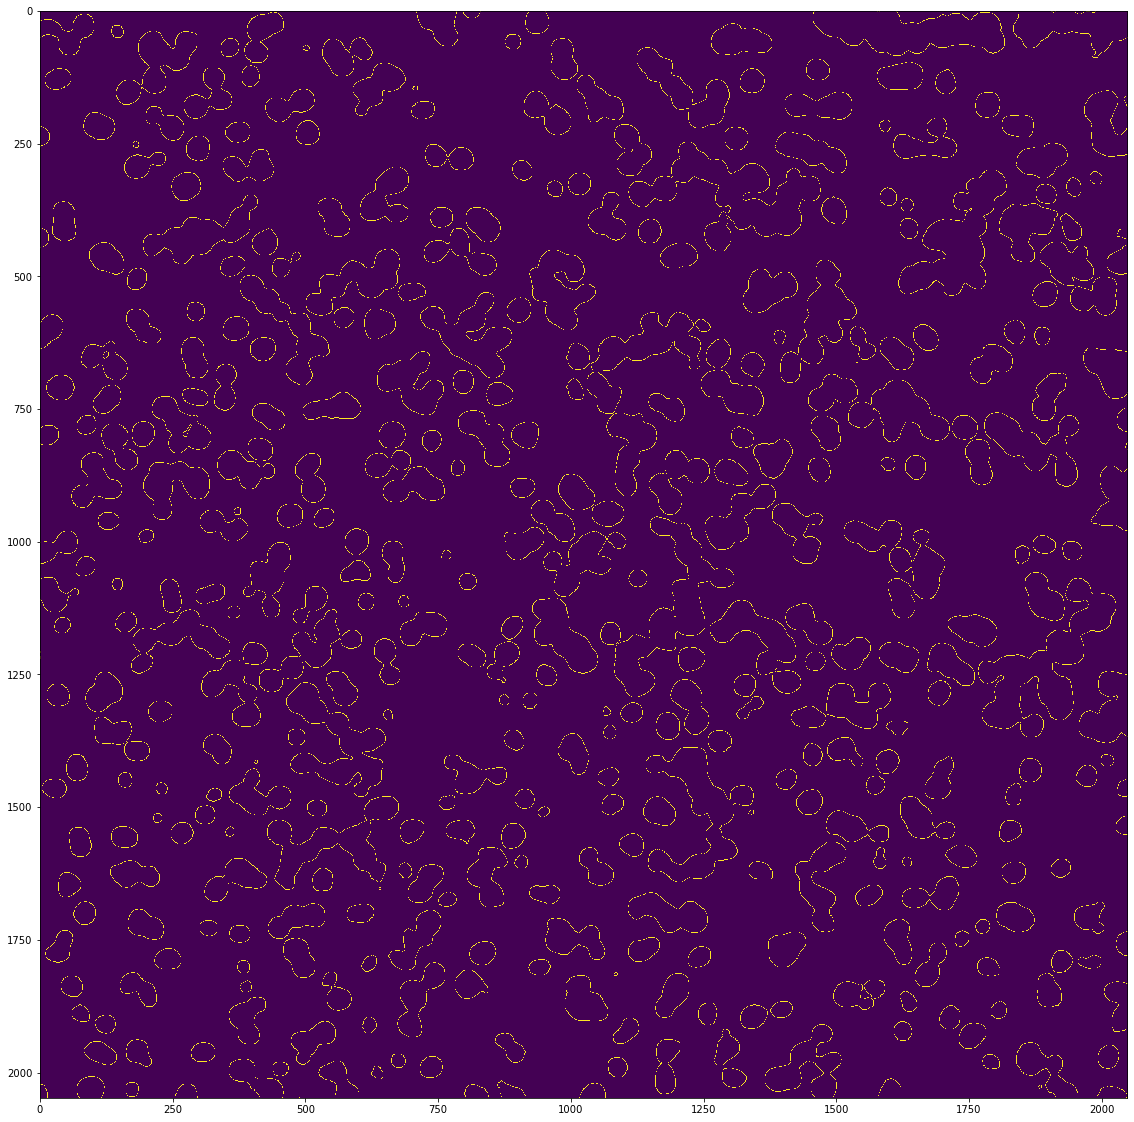

In [31]:
edges = cv2.Canny(filtered_img, 42, 64); plt.figure(figsize=(20,20)); plt.imshow(edges)

In [32]:
target = filtered_img
@interact(footprint=(1,100,1))   # Important parameter
def Segementation_by_maxi(footprint = 5):
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True); fig.tight_layout(); ax = axes.ravel()
    distance = ndi.distance_transform_edt(target, distances=10)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint, footprint)), labels=target)
    markers = ndi.label(local_maxi)[0]; labels = watershed(-distance, markers, mask=target)
    print('Number of objects detected: ', markers.max())
    ax[0].imshow(target, cmap=plt.cm.gray); ax[0].set_title(' objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray); ax[1].set_title('Distances'); 
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral); ax[2].set_title('Separated objects')
    return labels

interactive(children=(IntSlider(value=5, description='footprint', min=1), Output()), _dom_classes=('widget-int…

Number of objects detected:  69762


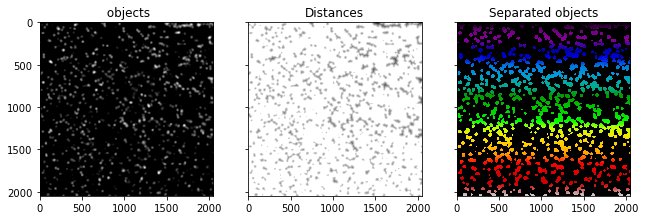

In [34]:
watershed_label = Segementation_by_maxi(footprint=8)

<b> Filter Watershed label by size (bad)

In [38]:
from skimage.measure import regionprops
import matplotlib.patches as mpatches

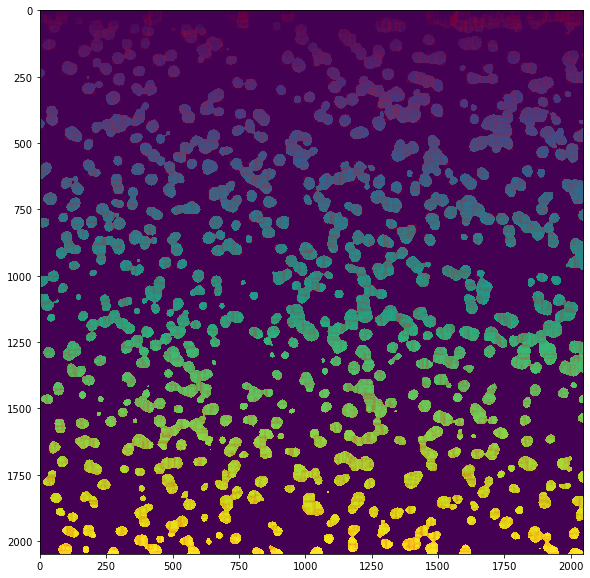

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(watershed_label)

for region in regionprops(watershed_label):
    # skip small images
    if region.area < 50:
        continue
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=0.1)
    ax.add_patch(rect)
plt.show()

# Using Maximum

In [16]:
image = filtered_img

In [17]:
image_max = scipy.ndimage.maximum_filter(image, size=15, mode='constant')
# Comparison between image_max and im to find the coordinates of local maxima
mh_maxima = mh.locmax(image_max)
loc_extrema = extrema.local_maxima(image)
h_extrema = extrema.h_maxima(image, h = 0.1)
coords = peak_local_max(image, min_distance=10, threshold_abs=5)

In [18]:
len(coords)

4507

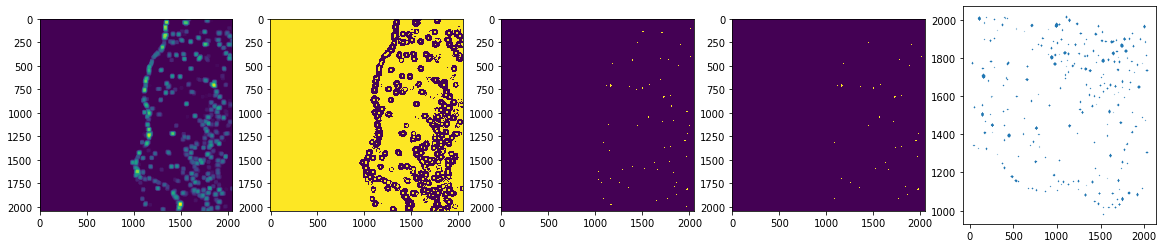

In [19]:
plt.figure(figsize=(20,4)); 
plt.subplot(151); plt.imshow(image_max)
plt.subplot(152); plt.imshow(mh_maxima,interpolation='nearest',filterrad=50)
plt.subplot(153); plt.imshow(loc_extrema)
plt.subplot(154); plt.imshow(h_extrema)
plt.subplot(155); plt.scatter( coords[:,0], coords[:,1], marker='.',s =0.1)

### Skimage

https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py

In [22]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])
myimg = plt.imread('FOV34_Cy3S.tif')

In [23]:
#g_filter, img_blurred, blurg_filter, filtered_img = CompareBlur_noBlur(15, 0.5)

In [24]:
img = filtered_img

Felzenszwalb number of segments: 496
SLIC number of segments: 256


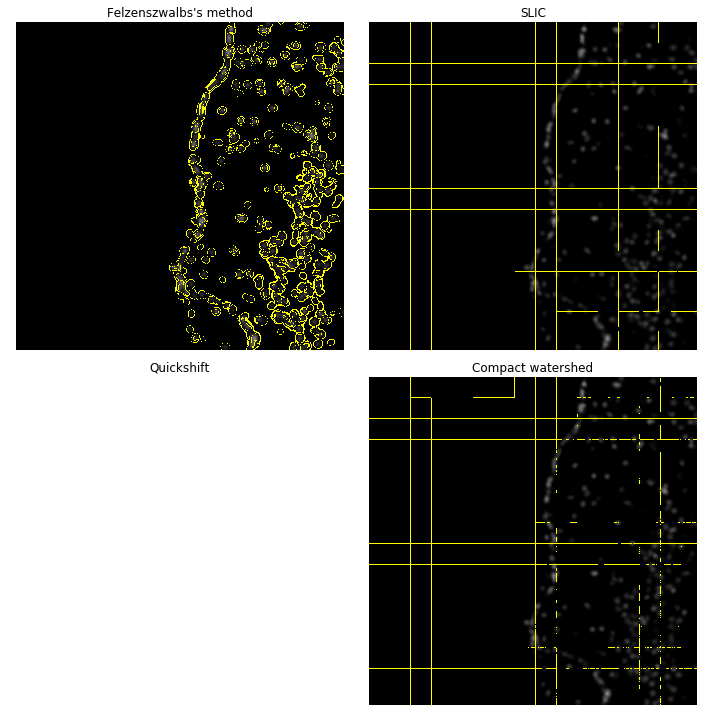

In [26]:
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
#segments_quick = quickshift(img_color, kernel_size=1, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
#print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
#ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout(); plt.show()

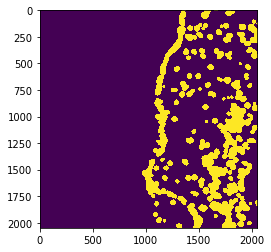

In [56]:
plt.imshow(ndi.binary_closing(segments_fz))

<b>Morphology-based

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))
    return _store
# Morphological ACWE
#image = img_as_float(data.camera())
image = filtered_img

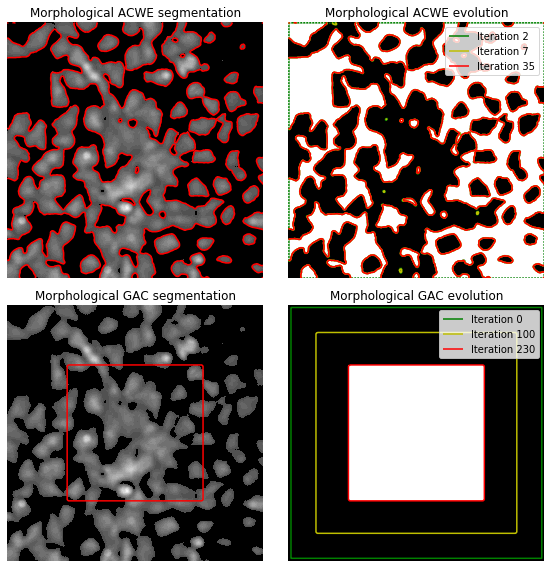

In [49]:
# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)


# Morphological GAC
#image = img_as_float(data.coins())
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[2].imshow(image, cmap="gray"); ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray"); ax[3].set_axis_off()

contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

<b> Filtering & Contrast Methods

In [60]:
dapi1 = plt.imread('Images/AV81_DAPI.tif')
dapi2 = plt.imread('Images/BD67_DAPI.tif')
dapi3 = plt.imread('Images/BE80_DAPI.tif')
dapi4 = plt.imread('Images/BK76_DAPI.tif')

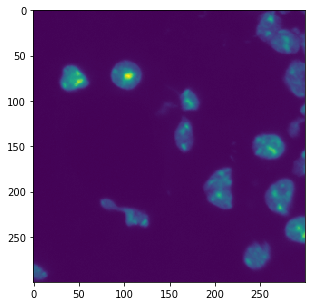

In [61]:
# Imports
import skimage.filters.rank as rank
plt.figure(figsize=(5,5));
dapi1_ex = dapi1[1500:1800,1350:1650]
plt.imshow(dapi1_ex)

<b>Mean Subtraction

C:\Users\Mo\.conda\envs\tf-gpu\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (22949), equivalent to an approximate bitdepth of 14.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


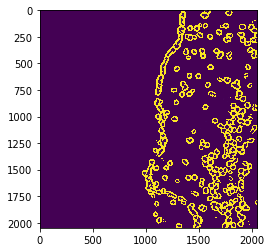

In [52]:
dapi1_f1 = rank.subtract_mean(dapi1, disk(20))
plt.imshow(dapi1_f1)

<b>Local Contrast

In [62]:
from skimage.filters.rank import enhance_contrast

C:\Users\Mo\.conda\envs\tf-gpu\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (15920), equivalent to an approximate bitdepth of 14.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


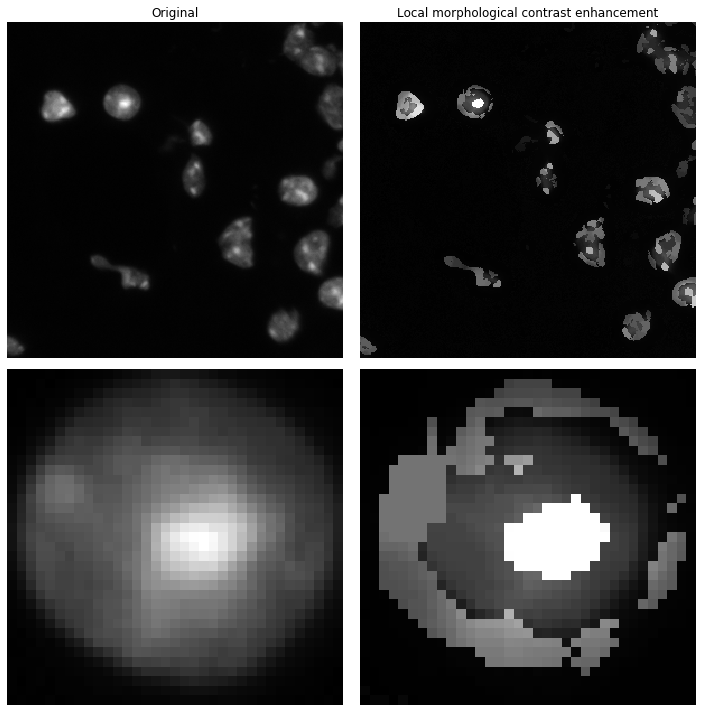

In [63]:
noisy_image = dapi1_ex
enh = enhance_contrast(noisy_image, disk(5))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex = 'row', sharey = 'row'); ax = axes.ravel()
ax[0].imshow(noisy_image, cmap=plt.cm.gray); ax[0].set_title('Original')
ax[1].imshow(enh, cmap=plt.cm.gray); ax[1].set_title('Local morphological contrast enhancement')
ax[2].imshow(noisy_image[55:90, 85:120], cmap=plt.cm.gray)
ax[3].imshow(enh[55:90, 85:120], cmap=plt.cm.gray)

for a in ax:
    a.axis('off')
plt.tight_layout()

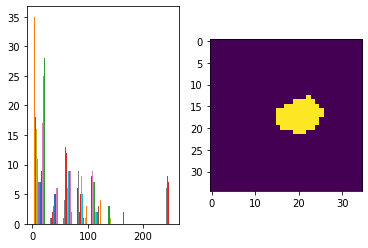

In [64]:
enh_norm = mh.stretch(enh[55:90, 85:120])
plt.subplot(121); hist_intensity = plt.hist(enh_norm)
thres = enh_norm.max()*0.9; thres_bin = hist_intensity[-2][-2]
plt.subplot(122); plt.imshow(enh_norm>thres_bin)